# Part 3: Practical Audit

In [2]:
!pip install aif360

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 8.1 MB/s eta 0:00:00


Data Summary:
Total samples: 5278
African-American: 3175
Caucasian: 2103
High risk predictions: 2525
Actual recidivism: 2483

Bias Analysis Results:

African-American:
  False Positive Rate: 0.423
  False Negative Rate: 0.285
  Precision: 0.650
  Recall: 0.715
  Accuracy: 0.649
  Positive Prediction Rate: 0.576
  Sample Size: 3175.000

Caucasian:
  False Positive Rate: 0.220
  False Negative Rate: 0.496
  Precision: 0.595
  Recall: 0.504
  Accuracy: 0.672
  Positive Prediction Rate: 0.331
  Sample Size: 2103.000

Disparity Analysis:
False Positive Rate Difference: 0.203
False Negative Rate Difference: -0.212
FPR Ratio (AA/Caucasian): 1.923


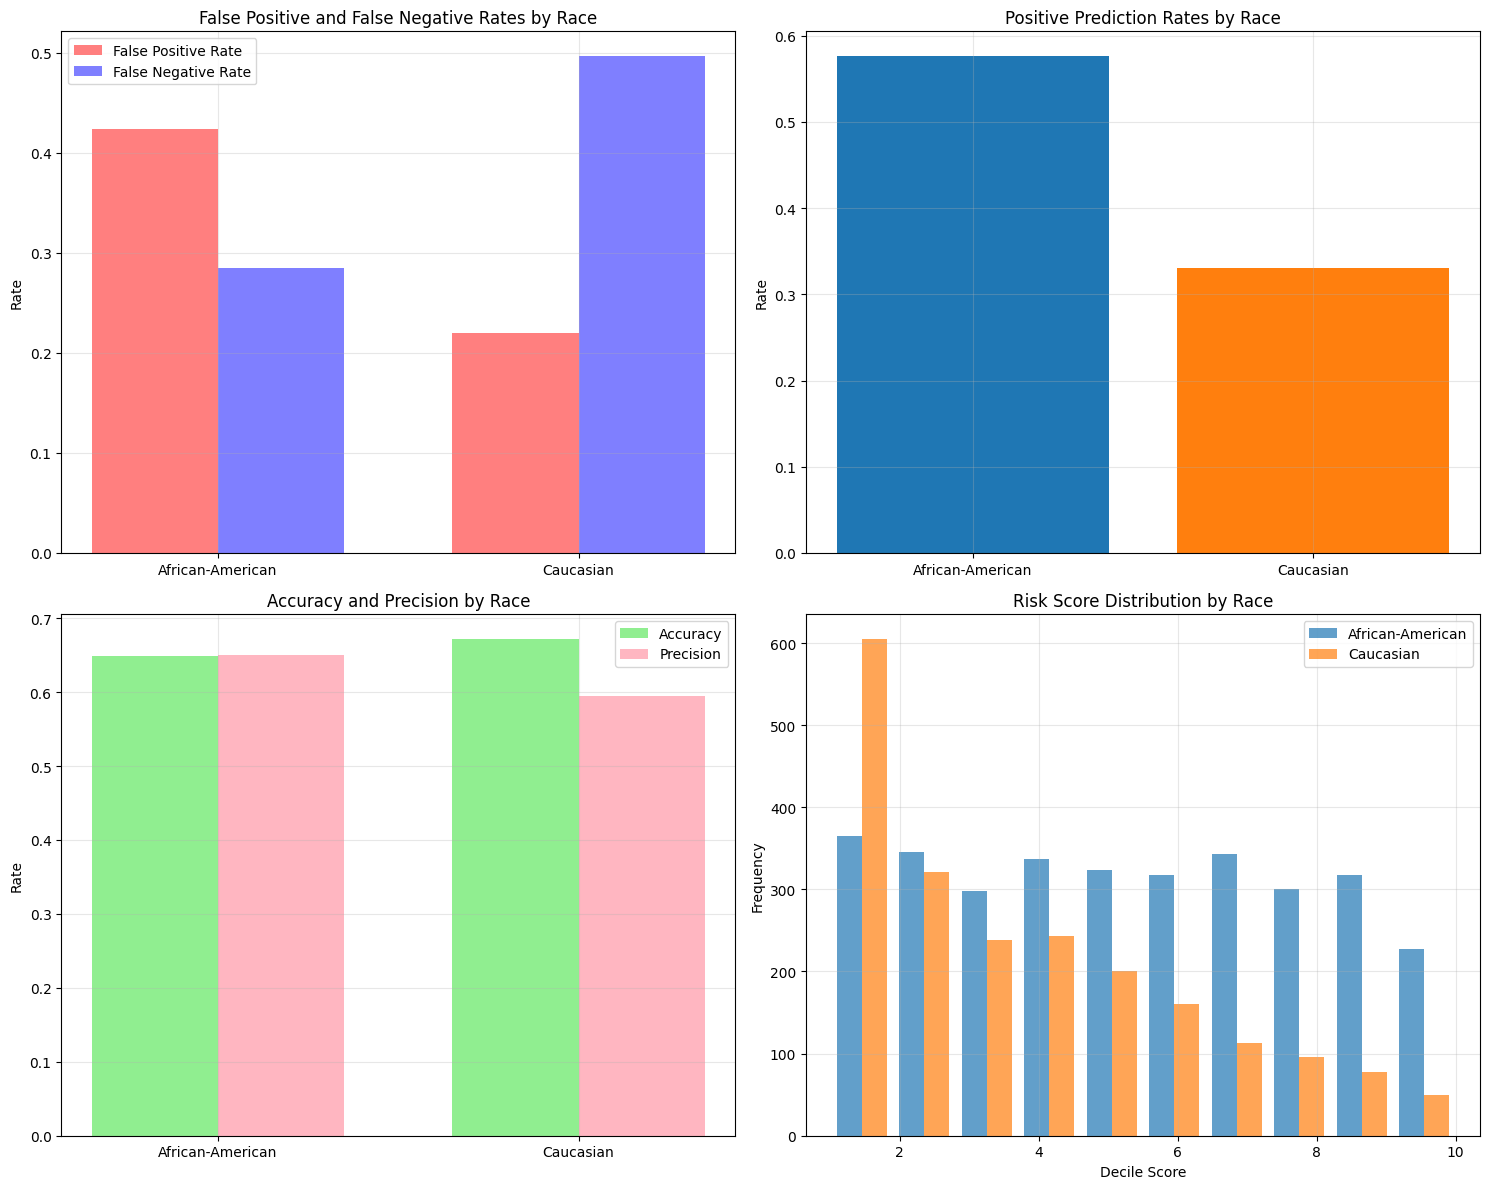


Correlation Analysis:
                age  priors_count  decile_score  recidivism  race_encoded
age           1.000         0.132        -0.400      -0.191         0.211
priors_count  0.132         1.000         0.440       0.287        -0.196
decile_score -0.400         0.440         1.000       0.368        -0.283
recidivism   -0.191         0.287         0.368       1.000        -0.130
race_encoded  0.211        -0.196        -0.283      -0.130         1.000

Summary Statistics by Race:
                     age         priors_count        decile_score         \
                    mean     std         mean    std         mean    std   
race                                                                       
African-American  32.435  10.585        4.238  5.436        5.277  2.828   
Caucasian         37.491  12.688        2.289  3.574        3.635  2.563   

                 recidivism         
                       mean    std  
race                                
African-Amer

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# Load and prepare the data
df = pd.read_csv('./sample_data/compas-scores-two-years.csv')

# Select and clean the data
df = df[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
         'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid']]

# Filter data (standard COMPAS analysis filters)
df = df[(df['days_b_screening_arrest'] <= 30) & (df['days_b_screening_arrest'] >= -30)]
df = df[df['is_recid'] != -1]
df = df[df['race'].isin(['African-American', 'Caucasian'])]  # Focus on these two groups

# Clean missing values
df = df.dropna()

# Convert categorical variables to numeric
le_race = LabelEncoder()
le_sex = LabelEncoder()
le_age_cat = LabelEncoder()
le_charge = LabelEncoder()

df['race_encoded'] = le_race.fit_transform(df['race'])
df['sex_encoded'] = le_sex.fit_transform(df['sex'])
df['age_cat_encoded'] = le_age_cat.fit_transform(df['age_cat'])
df['c_charge_degree_encoded'] = le_charge.fit_transform(df['c_charge_degree'])

# Create binary labels
df['high_risk'] = (df['decile_score'] >= 5).astype(int)
df['recidivism'] = df['two_year_recid']

print("Data Summary:")
print(f"Total samples: {len(df)}")
print(f"African-American: {len(df[df['race'] == 'African-American'])}")
print(f"Caucasian: {len(df[df['race'] == 'Caucasian'])}")
print(f"High risk predictions: {df['high_risk'].sum()}")
print(f"Actual recidivism: {df['recidivism'].sum()}")

# Calculate bias metrics manually 
def calculate_fairness_metrics(df):
    results = {}

    for race in ['African-American', 'Caucasian']:
        subset = df[df['race'] == race]

        # Confusion matrix components
        tp = len(subset[(subset['high_risk'] == 1) & (subset['recidivism'] == 1)])
        fp = len(subset[(subset['high_risk'] == 1) & (subset['recidivism'] == 0)])
        tn = len(subset[(subset['high_risk'] == 0) & (subset['recidivism'] == 0)])
        fn = len(subset[(subset['high_risk'] == 0) & (subset['recidivism'] == 1)])

        # Calculate rates
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        accuracy = (tp + tn) / (tp + fp + tn + fn) if (tp + fp + tn + fn) > 0 else 0

        # Positive prediction rate
        ppr = (tp + fp) / len(subset) if len(subset) > 0 else 0

        results[race] = {
            'False Positive Rate': fpr,
            'False Negative Rate': fnr,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'Positive Prediction Rate': ppr,
            'Sample Size': len(subset)
        }

    return results

# Calculate metrics
metrics = calculate_fairness_metrics(df)

print("\nBias Analysis Results:")
print("=" * 50)
for race, values in metrics.items():
    print(f"\n{race}:")
    for metric, value in values.items():
        print(f"  {metric}: {value:.3f}")

# Calculate disparities
aa_fpr = metrics['African-American']['False Positive Rate']
c_fpr = metrics['Caucasian']['False Positive Rate']
aa_fnr = metrics['African-American']['False Negative Rate']
c_fnr = metrics['Caucasian']['False Negative Rate']

print(f"\nDisparity Analysis:")
print(f"False Positive Rate Difference: {aa_fpr - c_fpr:.3f}")
print(f"False Negative Rate Difference: {aa_fnr - c_fnr:.3f}")
print(f"FPR Ratio (AA/Caucasian): {aa_fpr / c_fpr:.3f}" if c_fpr > 0 else "FPR Ratio: N/A")

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. False Positive and False Negative Rates
races = ['African-American', 'Caucasian']
fpr_rates = [metrics[race]['False Positive Rate'] for race in races]
fnr_rates = [metrics[race]['False Negative Rate'] for race in races]

x = np.arange(len(races))
width = 0.35

axes[0, 0].bar(x - width/2, fpr_rates, width, label='False Positive Rate', color='#ff7f7f')
axes[0, 0].bar(x + width/2, fnr_rates, width, label='False Negative Rate', color='#7f7fff')
axes[0, 0].set_title('False Positive and False Negative Rates by Race')
axes[0, 0].set_ylabel('Rate')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(races)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Positive Prediction Rates
ppr_rates = [metrics[race]['Positive Prediction Rate'] for race in races]
axes[0, 1].bar(races, ppr_rates, color=['#1f77b4', '#ff7f0e'])
axes[0, 1].set_title('Positive Prediction Rates by Race')
axes[0, 1].set_ylabel('Rate')
axes[0, 1].grid(True, alpha=0.3)

# 3. Accuracy and Precision
accuracy_rates = [metrics[race]['Accuracy'] for race in races]
precision_rates = [metrics[race]['Precision'] for race in races]

axes[1, 0].bar(x - width/2, accuracy_rates, width, label='Accuracy', color='#90EE90')
axes[1, 0].bar(x + width/2, precision_rates, width, label='Precision', color='#FFB6C1')
axes[1, 0].set_title('Accuracy and Precision by Race')
axes[1, 0].set_ylabel('Rate')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(races)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Risk Score Distribution
axes[1, 1].hist([df[df['race'] == 'African-American']['decile_score'],
                 df[df['race'] == 'Caucasian']['decile_score']],
                bins=10, alpha=0.7, label=['African-American', 'Caucasian'])
axes[1, 1].set_title('Risk Score Distribution by Race')
axes[1, 1].set_xlabel('Decile Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('compas_bias_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional analysis: Correlation between variables
print("\nCorrelation Analysis:")
corr_vars = ['age', 'priors_count', 'decile_score', 'recidivism', 'race_encoded']
correlation_matrix = df[corr_vars].corr()
print(correlation_matrix.round(3))

# Summary statistics
print("\nSummary Statistics by Race:")
summary_stats = df.groupby('race')[['age', 'priors_count', 'decile_score', 'recidivism']].agg(['mean', 'std']).round(3)
print(summary_stats)